In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input, BatchNormalization, ReLU, add, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

import random
import time

In [48]:
# Lista de GPU
devices = tf.config.list_physical_devices('GPU')

if devices:
    print(f"GPUs detectadas: {len(devices)}")
    for i, device in enumerate(devices):
        print(f"{i + 1}. {device}")
else:
    print("No se detectaron GPUs")

No se detectaron GPUs


In [2]:
# Fijar la semilla
semilla = 42

random.seed(semilla) # Python
np.random.seed(semilla) # NumPy y Pandas
tf.random.set_seed(semilla) # TensorFlow

In [53]:
metadata_path = '../datasets/CIFAR-100/meta'
train_path = '../datasets/CIFAR-100/train'
test_path = '../datasets/CIFAR-100/test'

In [54]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [55]:
metadata = unpickle(metadata_path)
fine_class_dict = dict(list(enumerate(metadata[b'fine_label_names'])))
super_class_dict = dict(list(enumerate(metadata[b'coarse_label_names'])))

In [11]:
super_class_dict

{0: b'aquatic_mammals',
 1: b'fish',
 2: b'flowers',
 3: b'food_containers',
 4: b'fruit_and_vegetables',
 5: b'household_electrical_devices',
 6: b'household_furniture',
 7: b'insects',
 8: b'large_carnivores',
 9: b'large_man-made_outdoor_things',
 10: b'large_natural_outdoor_scenes',
 11: b'large_omnivores_and_herbivores',
 12: b'medium_mammals',
 13: b'non-insect_invertebrates',
 14: b'people',
 15: b'reptiles',
 16: b'small_mammals',
 17: b'trees',
 18: b'vehicles_1',
 19: b'vehicles_2'}

In [137]:
train = unpickle(train_path)
data_train = train[b'data']
label_train = np.array(train[b'coarse_labels'])

In [123]:
data_train.shape

(50000, 3072)

In [124]:
label_train.shape

(50000,)

In [138]:
def shape_imagenes(img):
    num_imagenes = img.shape[0]
    
    # Dividir en los tres canales
    canales = img.reshape(num_imagenes, 3, 1024)
    
    # Reshape al ancho y alto de la imagen
    imagenes = canales.reshape(num_imagenes, 3, 32, 32)
    
    # Cambiar el orden a (num_imagenes, 32, 32, 3)
    imagenes = imagenes.transpose(0, 2, 3, 1)
    
    return imagenes

In [139]:
data_train = shape_imagenes(data_train)

In [140]:
data_train.shape

(50000, 32, 32, 3)

In [141]:
def malla_imagenes(img, label, classes):
    fig, axes = plt.subplots(5, 5, figsize=(16, 16))
    for i, ax in enumerate(axes.flat):
        ax.imshow(img[i])
        ax.set_title(classes[label[i]])
        ax.axis('off')
    plt.show()

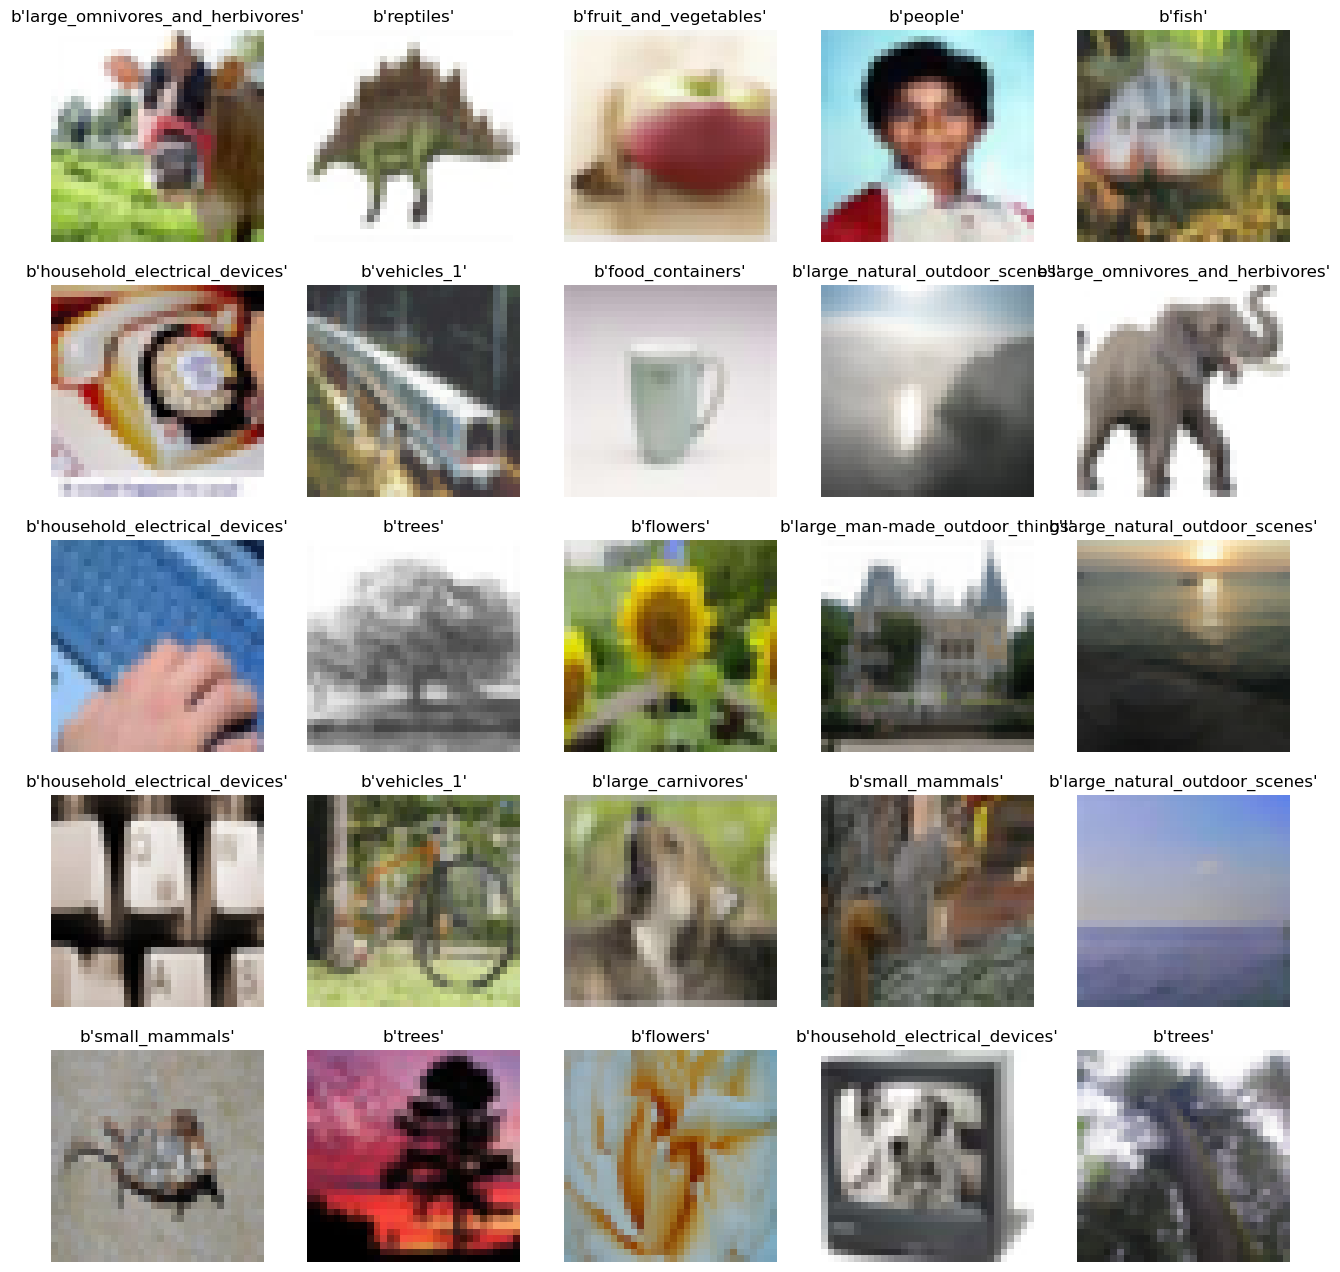

In [142]:
malla_imagenes(data_train, label_train, super_class_dict)

In [143]:
# Escalar las imágenes entre 0 y 1
data_train = data_train / 255.0

In [144]:
# Dividir en entrenamiento y validación (80/20)
trainX, validX, trainY, validY = train_test_split(data_train, label_train, test_size = 0.2, stratify = label_train, random_state = semilla)

In [145]:
trainX.shape

(40000, 32, 32, 3)

In [146]:
# Crear el modelo 1
def modelo1():
    func_activacion = 'relu'
    dropout = 0.2
    lr = 1e-3
    
    modelo = Sequential([
        Conv2D(filters=32, kernel_size=(3, 3), activation=func_activacion, padding='same', input_shape=(32, 32, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(dropout),
        
        Conv2D(filters=32, kernel_size=(3, 3), activation=func_activacion, padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(dropout),
    
        Flatten(),
    
        Dense(128, activation=func_activacion),
        Dropout(dropout),
    
        Dense(128, activation=func_activacion),
        Dropout(dropout),
    
        Dense(20, activation = "softmax")
    ])
    
    # Compilar el modelo
    modelo.compile(
        optimizer = Adam(learning_rate = lr),             
        loss = 'sparse_categorical_crossentropy',
        metrics = ['accuracy']
    )
    
    modelo.summary()

    return modelo

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_34 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_19 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                            
                                                                 
 dropout_35 (Dropout)        (None, 8, 8, 32)         

In [40]:
# Bloques de la resnet
def bloque(x, filtros, kernel_size = 3, stride = 1):
    residual = x

    x = Conv2D(filters = filtros, kernel_size = kernel_size, padding = 'same', strides = stride)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters = filtros, kernel_size = kernel_size, padding = 'same')(x)
    x = BatchNormalization()(x)

    if stride > 1:
        residual = Conv2D(filters = filtros, kernel_size = 1, padding = 'same', strides = stride)(residual)
    
    x = add([x, residual])
    x = ReLU()(x)

    return x


In [46]:
# Crear el modelo 2 (resnet)
def resnet(n, num_clases, input_shape = (32, 32, 3), lr = 1e-4):
    
    # Capa inicial
    input = Input(shape = input_shape)
    x = Conv2D(filters = 16, kernel_size = 3, padding = 'same')(input)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Cada etapa se compone de n bloques cuyas convoluciones utilizan los filtros correspondientes
    for etapa, filtros in enumerate([16, 32, 64]):
        for i in range(n):
            # Si es el primer bloque de la etapa se hace un submuestreo
            stride = 2 if etapa > 0 and i == 0 else 1
            
            x = bloque(x, filtros, stride = stride)

    # Aplanar y realizar la predicción final
    x = GlobalAveragePooling2D()(x)
    x = Dense(num_clases, activation = "softmax")(x)

    # Crear el modelo
    modelo = Model(inputs = input, outputs = x)
          
    # Compilar el modelo
    modelo.compile(
        optimizer = Adam(learning_rate = lr),             
        loss = 'sparse_categorical_crossentropy',
        metrics = ['accuracy']
    )

    return modelo

In [57]:
modelo2 = resnet(5, len(fine_class_dict))
modelo2.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_243 (Conv2D)            (None, 32, 32, 16)   448         ['input_16[0][0]']               
                                                                                                  
 batch_normalization_224 (Batch  (None, 32, 32, 16)  64          ['conv2d_243[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 re_lu_220 (ReLU)               (None, 32, 32, 16)   0           ['batch_normalization_224[0

In [ ]:
# Entrenamiento midiendo el tiempo
inicio = time.time()

history = modelo.fit(trainX, trainY, epochs = 100, validation_data = (validX, validY))

fin = time.time()

# Calcular el tiempo transcurrido
tiempo = fin - inicio
print(f"Tiempo de entrenamiento: {tiempo:.2f} segundos")

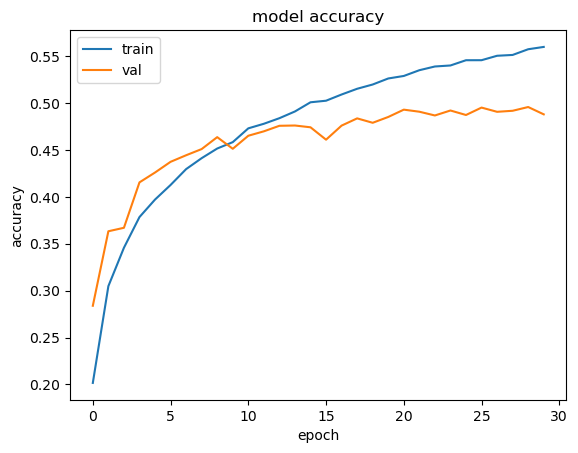

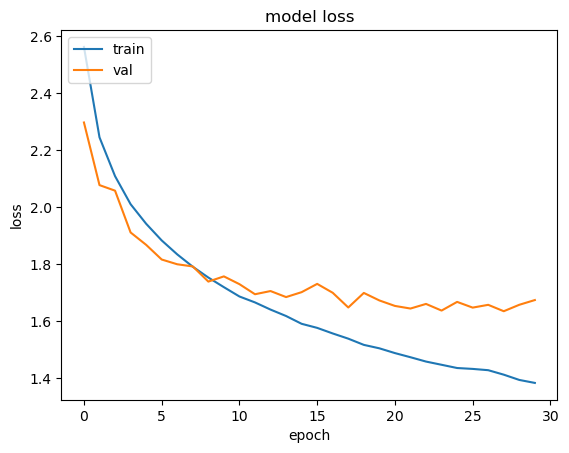

In [151]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [148]:
test = unpickle(test_path)
data_test = test[b'data']
label_test = np.array(test[b'coarse_labels'])

In [149]:
data_test = shape_imagenes(data_test)
data_test = data_test / 255.0

In [150]:
inicio = time.time()
modelo.evaluate(data_test, label_test)
fin = time.time()

tiempo = fin - inicio
print(f"Tiempo de inferencia: {tiempo:.2f} segundos")

313/313 [==============================] - 1s 4ms/step - loss: 1.6412 - accuracy: 0.4984
Tiempo de inferencia: 1.60 segundos
